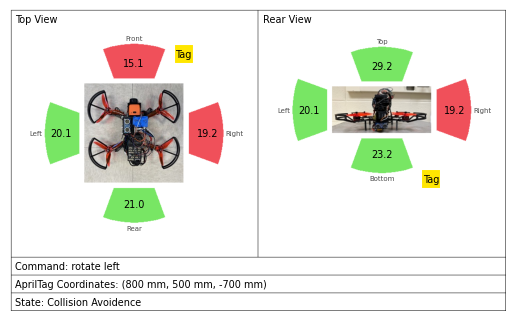

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# import GPIO readings here (in mm)
read_right = 19.2;
read_left = 20.1;
read_top = 29.2;
read_bottom = 23.2;
read_rear = 21.0;
read_front = 15.1;
trigger_dist = 20;

# import tag readings (in mm), estimates +/- 1000 mm, assumes tag is always in front
tag_x = 800; # - front / + rear, max +/- 1000
tag_y = 500; # + drone right / - drone left, max +/- 1000
tag_z = -700; # down in the front view window, max 1200

# import drone images
top_img = cv2.imread('DroneTop2.jpeg') 
RGB_top = cv2.cvtColor(top_img, cv2.COLOR_BGR2RGB)
front_img = cv2.imread('DroneRear.jpg')
RGB_front = cv2.cvtColor(front_img, cv2.COLOR_BGR2RGB)

# create blank
textbar = int(0.2*(0.9*RGB_top.shape[0]));
window = int(2.5*RGB_top.shape[0])
blank = 255 * np.ones(shape=[window+3*textbar+1, 2*window+1, 3], dtype=np.uint8)
plt.axis('off') # turn of axes for design
# colors
blocked = (240,80,90) # red
free = (120,230,100) # green

# color edit here
if read_right < trigger_dist: c_right = blocked
else: c_right = free
if read_left < trigger_dist: c_left = blocked
else: c_left = free
if read_rear < trigger_dist: c_rear = blocked
else: c_rear = free  
if read_front < trigger_dist: c_front = blocked
else: c_front = free
if read_top < trigger_dist: c_top = blocked
else: c_top = free  
if read_bottom < trigger_dist: c_bottom = blocked
else: c_bottom = free
    
# reference points
top_center = (int(0.5*window),int(0.5*window))
top_left = int(top_center[0]-0.5*RGB_top.shape[0])
top_right = int(top_center[0]+0.5*RGB_top.shape[0])
top_top = int(top_center[1]-0.5*RGB_top.shape[1])
top_bottom = int(top_center[1]+0.5*RGB_top.shape[1])

front_center = (int(0.5*window-0.5*RGB_front.shape[0]),int(1.5*window)) # format (y,x)
front_left = int(front_center[0]-0.5*RGB_front.shape[0])
front_right = int(front_center[0]+0.5*RGB_front.shape[0])
front_top = int(front_center[1]-0.5*RGB_front.shape[1])
front_bottom = int(front_center[1]+0.5*RGB_front.shape[1])

# colored flags
rnge = (int(0.9*RGB_top.shape[0]),int(0.9*RGB_top.shape[0]))
edge = int(0.05*RGB_top.shape[0])
front_center = (front_center[1],front_center[0])
align_offset = int(0.5*(RGB_top.shape[0]-RGB_front.shape[0]))

# colored wedges and white rectangle top view
cv2.ellipse(blank,top_center,rnge,0,-20,20,c_right,-1)
cv2.ellipse(blank,top_center,rnge,90,-20,20,c_rear,-1)
cv2.ellipse(blank,top_center,rnge,180,-20,20,c_left,-1)
cv2.ellipse(blank,top_center,rnge,270,-20,20,c_front,-1)
cv2.rectangle(blank,(top_left-edge,top_top-edge),(top_right+edge,top_bottom+edge),(255,255,255),-1)

# colored wedges and white rectangle rear view
cv2.ellipse(blank,front_center,rnge,0,-20,20,c_right,-1)
cv2.ellipse(blank,(front_center[0],front_center[1]-align_offset),rnge,90,-20,20,c_bottom,-1)
cv2.ellipse(blank,front_center,rnge,180,-20,20,c_left,-1)
cv2.ellipse(blank,(front_center[0],front_center[1]+align_offset),rnge,270,-20,20,c_top,-1)
cv2.rectangle(blank,(front_top-edge,front_left-edge),(front_bottom+edge,front_right+edge),(255,255,255),-1)

# insert top down drone image
blank[top_left:top_right, top_top:top_bottom,:] = RGB_top[0:RGB_top.shape[0],0:RGB_top.shape[1],:]

# insert front view drone image
blank[front_left:front_right, front_top:front_bottom,:] = RGB_front[0:RGB_front.shape[0],0:RGB_front.shape[1],:]

# boarder rectangles
cv2.rectangle(blank,(2,2),(window,window),(0,0,0),thickness = 1)
cv2.rectangle(blank,(window,2),(2*window,window),(0,0,0),thickness = 1)
cv2.rectangle(blank,(2,window),(2*window,window+textbar),(0,0,0),thickness = 1)
cv2.rectangle(blank,(2,window+textbar),(2*window,window+2*textbar),(0,0,0),thickness = 1)
cv2.rectangle(blank,(2,window+2*textbar),(2*window,window+3*textbar),(0,0,0),thickness = 1)

# command tree, begin by rotating toward tag
command = "start"
state = "start"

if read_front > trigger_dist and read_rear > trigger_dist and read_right > trigger_dist and read_left > trigger_dist and read_top > trigger_dist and read_bottom > trigger_dist: # all clear
    state = "Tracking"
    if tag_y < 0:
        command= "rotate left to tag then move forward"
    elif tag_y > 0:
        command = "rotate right to tag then move forward"
    elif tag_y == 0:
        command = "move forward to tag"
    
else: 
    state = "Collision Avoidence"
    if read_front >= trigger_dist:
        command = "move forward to tag"
    elif read_front < trigger_dist:
        if read_left >= trigger_dist:
    #         while read_front <= trigger_dist:
            command = "rotate left"
        elif read_right >= trigger_dist:
    #         while read_front <= trigger_dist:
            command = "rotate right"
        elif read_rear >= trigger_dist:
    #         while (read_left < trigger_dist and rear_read > trigger_dist) or (read_right < trigger_dist and rear_read > trigger_dist):
            command = "move backwards"
            if read_left > trigger_dist:
    #             while read_front <= trigger_dist:
                command = "rotate left"
            elif read_right > trigger_dist:
    #              while read_front <= trigger_dist:
                command = "rotate right"
    else:
        command = "stuck, opt for altitude change"
    

# explanatory text
text_edge = int(0.05*RGB_top.shape[0])
plt.text(text_edge, text_edge, 'Top View', horizontalalignment='left',verticalalignment='top',size = 7)
plt.text(window+text_edge, text_edge, 'Rear View', horizontalalignment='left',verticalalignment='top',size = 7)
plt.text(text_edge, int(window+0.5*textbar), "Command: "+command, horizontalalignment='left',verticalalignment='center',size = 7)
plt.text(text_edge, int(window+1.5*textbar), "AprilTag Coordinates: "+"("+str(tag_x)+" mm, "+str(tag_y)+" mm, "+str(tag_z)+" mm)", horizontalalignment='left',verticalalignment='center',size = 7)
plt.text(text_edge, int(window+2.5*textbar), "State: "+state, horizontalalignment='left',verticalalignment='center',size = 7)

# direction label top view
plt.text(top_center[0], top_center[1] - (rnge[0]+5), 'Front', horizontalalignment='center',verticalalignment='bottom',size = 5,color=[0.3,0.3,0.3])
plt.text(top_center[0], top_center[1] + (rnge[0]+5), 'Rear', horizontalalignment='center',verticalalignment='top',size = 5,color=[0.3,0.3,0.3])
plt.text(top_center[0] - (rnge[0]+5), top_center[1], 'Left', horizontalalignment='right',verticalalignment='center',size = 5,color=[0.3,0.3,0.3])
plt.text(top_center[0] + (rnge[0]+5), top_center[1], 'Right', horizontalalignment='left',verticalalignment='center',size = 5,color=[0.3,0.3,0.3])

# friction label front view
plt.text(front_center[0],front_center[1]-(rnge[0]+5)+int(0.5*(RGB_top.shape[0]-RGB_front.shape[0])), 'Top', horizontalalignment='center',verticalalignment='bottom',size = 5,color=[0.3,0.3,0.3])
plt.text(front_center[0],front_center[1]+(rnge[0]+5)-int(0.5*(RGB_top.shape[0]-RGB_front.shape[0])), 'Bottom', horizontalalignment='center',verticalalignment='top',size = 5,color=[0.3,0.3,0.3])
plt.text(front_center[0] - (rnge[0]+5), front_center[1], 'Left', horizontalalignment='right',verticalalignment='center',size = 5,color=[0.3,0.3,0.3])
plt.text(front_center[0] + (rnge[0]+5), front_center[1], 'Right', horizontalalignment='left',verticalalignment='center',size = 5,color=[0.3,0.3,0.3])

# distance reading here
# flag distance top text
plt.text(top_center[0], top_center[1] - (rnge[0]+5) + 53, read_front, horizontalalignment='center',verticalalignment='bottom',size = 7)
plt.text(top_center[0], top_center[1] + (rnge[0]+5) - 53, read_rear, horizontalalignment='center',verticalalignment='top',size = 7)
plt.text(top_center[0] - (rnge[0]+5) + 59, top_center[1], read_left, horizontalalignment='right',verticalalignment='center',size = 7)
plt.text(top_center[0] + (rnge[0]+5) - 59, top_center[1], read_right, horizontalalignment='left',verticalalignment='center',size = 7)

# flag distance front text
plt.text(front_center[0],front_center[1]-(rnge[0]+5)+56+50, read_top, horizontalalignment='center',verticalalignment='bottom',size = 7)
plt.text(front_center[0],front_center[1]+(rnge[0]+5)-56-50, read_bottom, horizontalalignment='center',verticalalignment='top',size = 7)
plt.text(front_center[0] - (rnge[0]+5)+59, front_center[1], read_left, horizontalalignment='right',verticalalignment='center',size = 7)
plt.text(front_center[0] + (rnge[0]+5)-59, front_center[1], read_right, horizontalalignment='left',verticalalignment='center',size = 7)

# tag bound management
if tag_x <= 1000 and tag_x >= -1000:
    top_fr = tag_x/5
elif tag_x > 1000:
    top_fr = 1000
elif tag_x < -1000:
    top_fr = -1000
else:
    top_fr = 0
    
if tag_y <= 1000 and tag_y >= -1000:
    top_rl = tag_y/5
elif tag_y > 1000:
    top_rl = 1000
elif tag_y < -1000:
    top_rl = -1000
else:
    top_rl = 0

if tag_z >= -1200 and tag_z <= 0:
    front_tb = tag_z/5
elif tag_z < -1200:
    front_tb = -1200
else:
    front_tb = 0

plt.plot(top_rl+top_center[0], -top_fr+top_center[1], marker="s", markersize=15, markeredgecolor="white",markeredgewidth=1.5, markerfacecolor=[1,0.9,0])
plt.plot(top_rl+front_center[0], -front_tb+front_center[1], marker="s", markersize=15, markeredgecolor="white", markeredgewidth=1.5, markerfacecolor=[1,0.9,0])
plt.text(top_rl+top_center[0], -top_fr+top_center[1], "Tag", horizontalalignment='center',verticalalignment='center',size = 7,color="black")
plt.text(top_rl+front_center[0], -front_tb+front_center[1], "Tag", horizontalalignment='center',verticalalignment='center',size = 7,color="black")

plt.imshow(blank)
plt.show()

# 